In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
def entropy_KL1(data):
    #KL entropy estimator, with k=1 nearest neighbor
    k= 1
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data.transpose())
    distances, indices = nbrs.kneighbors(data.transpose())
    dist_nearest = (distances[:,1]).transpose()
    if data.shape[0] == 1:
        vols_nearest = 2*dist_nearest
    elif data.shape[0] == 2:
        vols_nearest = np.pi * (dist_nearest)**2
    Hhat = np.log(k) + .5772156 + (1/data.shape[1]) * np.sum(np.log(data.shape[1]/k*vols_nearest))
    return Hhat

In [3]:
#Sliced MI functions using entropy_KL1 as 1-dimensional entropy estimator
def project_data(data, theta):
    return np.expand_dims(theta @ data,axis=0)

def sliced_MI(dataX, dataY, nMC):
    dX = dataX.shape[0]
    dY = dataY.shape[0]
    MI_slice = np.zeros(nMC)
    for i in range(nMC):
        #generate theta, phi
        vecT = np.random.randn(dX)
        theta = vecT/np.linalg.norm(vecT)
        vecP = np.random.randn(dY)
        phi = vecP/np.linalg.norm(vecP)
        #Project
        Xproj = project_data(dataX,theta)
        Yproj = project_data(dataY,phi)
        #Estimate sliced MI
        MI_slice[i] = -entropy_KL1(np.vstack((Xproj, Yproj))) + entropy_KL1(Xproj) + entropy_KL1(Yproj)
        
    return np.mean(MI_slice), MI_slice


In [10]:
#Demo experiment:
#     SMI between subsets of an 5-dimensional standard normal random vector X, specifically SMI(X_{0:3}; X_{1:4})
#     

#Number of independent experiments to smooth the plots
nmc = 20
#Maximum dataset size/number of slices to plot
n = 100
#mags = np.random.rand(15)
mn_est = np.zeros(nmc)
ns = (np.ceil(np.logspace(1, np.log10(n), 5))).astype(int)
val0 = np.zeros((nmc,len(ns)))
val1 = np.zeros((nmc,len(ns)))
val2 = np.zeros((nmc,len(ns)))
for j in range(nmc):
    data = np.random.randn(5, 10*n)
    X = data[0:3,:]
    Y = data[1:4,:] 
    mn_est[j], MI_slice = sliced_MI(X,Y, n)
    ests = np.cumsum(MI_slice) / np.arange(1,n + 1)



    ns = (np.ceil(np.logspace(1, np.log10(n), 5))).astype(int)
    
    #For each value in ns, SMI computed using ns slices and 10*n datapoints
    val0[j,:] = ests[ns-1]
    
    for i in range(len(ns)):
        #For each value in ns, SMI computed using ns datapoints and 10*n slices
        val1[j,i],dummy = sliced_MI(X[:,:ns[i]], Y[:,:ns[i]], n)
        #For each value in ns, SMI computed using ns slices and ns datapoints
        val2[j,i],dummy = sliced_MI(X[:,:ns[i]], Y[:,:ns[i]], ns[i])
        print(str(j) + ',' + str(i))
    
mn = np.mean(mn_est)

0,0
0,1
0,2
0,3
0,4
1,0
1,1
1,2
1,3
1,4
2,0
2,1
2,2
2,3
2,4
3,0
3,1
3,2
3,3
3,4
4,0
4,1
4,2
4,3
4,4
5,0
5,1
5,2
5,3
5,4
6,0
6,1
6,2
6,3
6,4
7,0
7,1
7,2
7,3
7,4
8,0
8,1
8,2
8,3
8,4
9,0
9,1
9,2
9,3
9,4
10,0
10,1
10,2
10,3
10,4
11,0
11,1
11,2
11,3
11,4
12,0
12,1
12,2
12,3
12,4
13,0
13,1
13,2
13,3
13,4
14,0
14,1
14,2
14,3
14,4
15,0
15,1
15,2
15,3
15,4
16,0
16,1
16,2
16,3
16,4
17,0
17,1
17,2
17,3
17,4
18,0
18,1
18,2
18,3
18,4
19,0
19,1
19,2
19,3
19,4


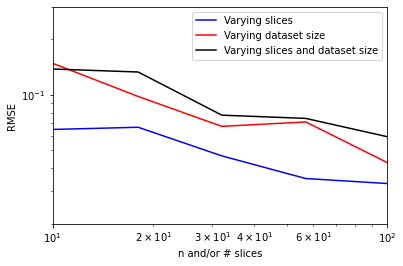

In [12]:
#Best estimate available for the true value of the SMI (10*n datapoints, n*nmc slices)
mn = np.mean(val0[:,-0])

#Plot results showing RMSE to this estmated true value
plt.loglog(ns, np.sqrt(np.sum((np.abs(val0 - mn))**2,axis=0)/nmc),'b-', label = 'Varying slices')
plt.loglog(ns, np.sqrt(np.sum((np.abs(val1 - mn))**2,axis=0)/nmc), 'r-', label = 'Varying dataset size')
plt.loglog(ns, np.sqrt(np.sum((np.abs(val2 - mn))**2,axis=0)/nmc), 'k-', label = 'Varying slices and dataset size')
plt.axis([10,n,20e-3,.3])
plt.ylabel('RMSE')
plt.xlabel('n and/or # slices')
plt.legend()
#plt.savefig('MI_convergence_d10_s1000.eps')